In [8]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

# GSDC Raw Data Overview

In [ ]:
glob.glob("./data/raw_data/*")

In [9]:
all_compounds_screened = pd.read_csv("data/raw_data/all_compounds_screened.csv")
all_cellines_screened = pd.read_excel("data/raw_data/all_cellines_screened.xlsx", sheet_name=0)
all_experiment = pd.read_excel("data/raw_data/GDSC2_drug_dose_cellines_IC50s.xlsx")

/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [10]:
# 选取有测序结果和甲基化数据等数据的细胞系
filtered_celline = all_cellines_screened.loc[
    (all_cellines_screened['Whole Exome Sequencing (WES)'] == "Y") &
    (all_cellines_screened['Methylation'] == "Y") &
    (all_cellines_screened['Gene Expression'] == "Y") &
    (all_cellines_screened['Copy Number Alterations (CNA)'] == "Y") &
    (all_cellines_screened['Drug\nResponse'] == "Y")
]
filtered_celline.head()

,Sample Name,COSMIC identifier,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
0,A253,906794.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,NaN,MSS/MSI-L,D/F12,Adherent
1,BB30-HNC,753531.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
2,BB49-HNC,753532.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
3,BHY,753535.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
4,BICR10,1290724.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent


In [11]:
filtered_celline.head()

,Sample Name,COSMIC identifier,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
0,A253,906794.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,NaN,MSS/MSI-L,D/F12,Adherent
1,BB30-HNC,753531.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
2,BB49-HNC,753532.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
3,BHY,753535.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
4,BICR10,1290724.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent


In [12]:
a = set(all_experiment['CELL_LINE_NAME'])
b = set(filtered_celline['Sample Name'])
print(f"experiment sheet includes {a.__len__()} unqiue cellines")
print(f"all_celline sheet includes {b.__len__()} unique cellines")
celline_barcode = list(a.intersection(b))
print(f"two sheets have {celline_barcode.__len__()} overlapping cellines")

experiment sheet includes 969 unqiue cellines
all_celline sheet includes 928 unique cellines
two sheets have 870 overlapping cellines


# Single Celline Multi-omics data Overview

## Copy Number Variation and FPKM file readin 

In [26]:
all_cna = pd.read_csv("./data/raw_data/celline_SNP6_cnv_gistics_20191101/cnv_gistic_20191101.csv", low_memory=False,
                      skiprows=lambda x: x in [0, 2])
all_fpkm = pd.read_csv("./data/raw_data/cellines_rnaseq_all_20220624/rnaseq_fpkm_20220624.csv", low_memory=False,
                       skiprows=lambda x: x in [0, 2, 3, 4])

## Datasets Alignment

In [ ]:
all_fpkm = all_fpkm.drop(columns=['model_name'])
all_fpkm.rename(columns={"Unnamed: 1": "celline_barcode"}, inplace=True)
all_fpkm.set_index('celline_barcode', inplace=True)
all_fpkm = all_fpkm.T
all_fpkm.fillna(0.0, inplace=True)

In [ ]:
all_cna = all_cna.drop(columns=['model_name'])
all_cna.rename(columns={"Unnamed: 1": "celline_barcode"}, inplace=True)
all_cna.set_index('celline_barcode', inplace=True)
all_cna = all_cna.T
all_cna.fillna(0.0, inplace=True)

In [ ]:
s1 = set(all_fpkm.index).intersection(celline_barcode)
s2 = set(all_cna.index).intersection(celline_barcode)
celline_barcode = list(s1.intersection(s2))
print(f"Two datasets have {len(celline_barcode)} common cellines")

In [ ]:
common_genes = list(set(cna_df.columns).intersection(fpkm_df.columns))
print(f"Two datasets have {len(common_genes)} genes(features)")

In [ ]:
all_fpkm.loc[celline_barcode].to_csv("./data/processed_data/fpkm.csv", sep='\t')
all_cna.loc[celline_barcode].to_csv("./data/processed_data/cna.csv", sep='\t')
all_fpkm = all_fpkm.loc[celline_barcode]
all_cna = all_cna.loc[celline_barcode]

## GDSC Dataset

Filter dataset

In [ ]:
# drug_info: https://www.cancerrxgene.org/downloads/drug_data
drug_df = pd.read_csv('./data/raw_data/drug_info.csv', sep=',')
drug_df.head()

In [ ]:
# pubchem_id exclude non-numeric rows
import re
nonnumber = re.compile(r'\D+')
pubchem_id = list(set(drug_df['pubchem']))
pubchem_id = [i.split(',')[0] if "," in i else i for i in pubchem_id]
pubchem_id = [i for i in pubchem_id if re.findall(pattern=nonnumber, string=i).__len__()==0]
drug_df = drug_df[drug_df['pubchem'].isin(pubchem_id)]

In [ ]:
all_experiment.join(drug_df.set_index('drug_name'), on='DRUG_NAME', how="inner")

In [ ]:
all_experiment = all_experiment[all_experiment['CELL_LINE_NAME'].isin(celline_barcode)]
all_experiment.reset_index(inplace = True)
all_experiment.drop(columns = "index", inplace = True)
all_experiment

In [ ]:
all_experiment.to_csv("./data/processed_data/expriment.csv", sep="\t", index = None)

## Response and Pubchem ID troubleshooting

In [ ]:
import pubchempy as pcp
df = pcp.get_properties(properties=['canonical_smiles'], identifier=list(all_experiment['pubchem']),
                        namespace='cid', )
df = pd.DataFrame(df)
df[['CID']]=df[['CID']].astype(str)
df.to_csv("./data/processed_data/pubchem_id-SMILES.csv", sep='\t')
lookup_table_cid_smiles = dict(zip(df['CID'], df['CanonicalSMILES']))

In [ ]:
all_experiment = all_experiment[all_experiment['PUBCHEM_ID'].isin(pubchem_id)]
all_experiment['SMILES']=[lookup_table_cid_smiles[i] for i in all_experiment['PUBCHEM_ID']]

In [ ]:
all_experiment.shape

In [ ]:
sample_barcode = [f"{i[0]}_{i[1]}" for i in zip(all_experiment['CELL_LINE_NAME'], all_experiment['PUBCHEM_ID'])]

In [ ]:
response = pd.DataFrame()
response['sample_barcode'] = sample_barcode
response['LN_IC50'] = all_experiment['LN_IC50']
response.reset_index(drop=True, inplace=True)

**exclude outliers**

In [ ]:
from matplotlib import pyplot
ln_ic50 = all_experiment['LN_IC50'].values
df = pd.DataFrame(ln_ic50)

lower, median, upper = df.quantile([0.15,0.5,0.85]).values
IQR = upper - lower
lower_limit = lower - 1.5*IQR
upper_limit = upper + 1.5*IQR

all_experiment.loc[(all_experiment['LN_IC50'] < upper_limit.data) &
                   (all_experiment['LN_IC50'] > lower_limit.data)]

all_experiment.reset_index(drop=True, inplace=True)

In [ ]:
response.to_csv('./data/processed_data/response.csv', sep='\t', index=None)
all_experiment.to_csv('./data/processed_data/expriment.csv', sep='\t', index=None)

## Drug Feature Extraction using beta-VAE

In [7]:
import pandas as pd
from os.path import realpath
import pandas as pd
from keras.models import load_model
import ast
import pandas as pd
import numpy as np
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType

RDLogger.DisableLog("rdApp.*")

SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br"]'

bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}
bond_mapping.update(
    {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC}
)
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

BATCH_SIZE = 100
EPOCHS = 10

VAE_LR = 5e-4
NUM_ATOMS = 120  # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 435  # Size of the latent space


def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    # Ignore Pt Atom
    for atom in molecule.GetAtoms():
        if(atom.GetSymbol() == "Pt"):
            continue
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


def graph_to_molecule(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule


# 注：min-Max归一化需要在分割完训练集和测试集和Validation set之后再进行

# Cached_data
cached_data = {}

# Path Define
cna_path = realpath("data/processed_data/cna.csv")
experiment_path = realpath("data/processed_data/experiment.csv")
fpkm_path = realpath("data/processed_data/fpkm.csv")
SMILES_path = realpath("data/processed_data/pubchem_id-SMILES.csv")

drug_AdjacencyTensor = []
drug_FeatureTensor = []

df = pd.read_csv(SMILES_path, sep='\t')
for i in df["CanonicalSMILES"]:
    _ad, _fe = smiles_to_graph(i)
    drug_AdjacencyTensor.append(_ad)
    drug_FeatureTensor.append(_fe)

drug_AdjacencyTensor = np.array(drug_AdjacencyTensor)
drug_FeatureTensor = np.array(drug_FeatureTensor)

vae = load_model("utils/drug-molecule-generation-with-VAE",
               compile=False)

z_mean, _ = vae.encoder.predict([drug_AdjacencyTensor[:1000], drug_FeatureTensor[:1000]])

6/6 [==============================] - 0s 4ms/step


In [13]:
df[df['CID'].duplicated()]

,Unnamed: 0,CID,CanonicalSMILES
165,165,51042438,CN1C(=C(C=N1)Cl)C2=C(OC(=C2)C(=O)NC(CC3=CC(=C(...


In [8]:
drug_feature_df = pd.DataFrame(data = z_mean)

In [ ]:
drug_feature_df.head(5) # 435-dim vector

## CNA 和 Gene-Expression dimension reduction

**CNA and FPKM data integration using SNF**

SNFtool: https://doi.org/10.1038/nmeth.2810

R code is in current folder/SNL_integration.R

In [ ]:
!R CMD BATCH ./SNL_integration.R

In [ ]:
similarity_df = pd.read_csv("data/processed_data/simlilarity_matrix.csv")

In [ ]:
similarity_df.drop(columns=['Unnamed: 0'], inplace=True)
similarity_df.head()

In [ ]:
celline_feature = {}
for i, celline in enumerate(similarity_df.columns):
    celline_feature[celline] = np.array(similarity_df.iloc[i].values)

In [ ]:
s = []
for i in response['sample_barcode']:
    celline_name, pubchem_id = i.split('_')
    celline_feature_array = celline_feature[celline_name]
    drug_feature_array = drug_feature_df.loc[int(pubchem_id)]
    combined_feature = np.hstack([celline_feature_array, drug_feature_array])
    s.append(combined_feature)
    

In [ ]:
np.array(s).shape # 866+435=1301-dim vector

In [ ]:
np.save("./data/processed_data/all_feature", np.array(s))

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data = np.load('./data/processed_data/all_feature.npy')
response = pd.read_csv('./data/processed_data/response.csv', sep='\t')


In [ ]:
import tensorflow as tf
from tensorflow.data import Dataset
from sklearn.preprocessing import MinMaxScaler

In [ ]:
features = tf.constant(data)
labels = response['LN_IC50'].values


In [ ]:
scaler = MinMaxScaler()
labels = labels.reshape(-1,1)
scaler.fit(labels)
labels = scaler.transform(labels)

Other Method


In [ ]:
from sklearn.model_selection import train_test_split
data = np.load('./data/processed_data/all_feature.npy')
response = pd.read_csv('./data/processed_data/response.csv', sep='\t')
#features = tf.constant(data)
labels = response['LN_IC50'].values
scaler = MinMaxScaler()
labels = labels.reshape(-1,1)
scaler.fit(labels)
labels = scaler.transform(labels)
#labels = np.squeeze(1)
#labels = tf.constant(labels)
# dataset = Dataset.from_tensors((features, labels))


X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.losses import MeanSquaredError, BinaryCrossentropy
from keras import Model
from keras.metrics import Accuracy, AUC
import pandas as pd
from keras.models import Sequential
from keras import layers
import numpy as np
from tensorflow.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

data = np.load('./data/processed_data/all_feature.npy')
response = pd.read_csv('./data/processed_data/response.csv', sep='\t')
#features = tf.constant(data)
labels = response['LN_IC50'].values
scaler = MinMaxScaler()
labels = labels.reshape(-1,1)
scaler.fit(labels)
labels = scaler.transform(labels)
# labels = np.squeeze(1)
#labels = tf.constant(labels)
# dataset = Dataset.from_tensors((features, labels))

y = []
for i in labels:
    if (i[0]<=0.67):
        y.append(1)
    else:
        y.append(0)
labels = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, 
                                                    random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
y_pred = clf.predict(X_test)
precision_score(y_test, y_pred)


In [ ]:
recall_score(y_test, y_pred)


## MOFA analysis

In [27]:
from model.data import Dataset
import pandas as pd
import numpy as np
import muon

In [28]:
_data = Dataset()
procssed_data = _data.return_data()

In [29]:
gene_expression = procssed_data['omics_data']['gene_expression']
cnv = procssed_data['omics_data']['cnv']
response = procssed_data['response']
experiment = procssed_data['experiment']

In [31]:
cnv

celline_barcode,A1BG,A1CF,A2M,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,A4GNT,AAAS,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZZEF1,ZZZ3
T47D,2.0,4.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,4.0,...,4.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0
SKG-IIIa,3.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,...,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
SK-UT-1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
G-MEL,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,...,2.0,1.0,1.0,2.0,3.0,4.0,3.0,4.0,2.0,2.0
NCI-H1869,3.0,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,...,5.0,2.0,2.0,4.0,4.0,3.0,4.0,5.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCI-H1836,3.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,...,3.0,2.0,2.0,4.0,3.0,2.0,3.0,4.0,3.0,3.0
SW872,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,2.0,2.0,2.0,3.0,3.0,4.0,3.0,5.0,4.0,3.0
SJRH30,5.0,4.0,5.0,5.0,5.0,5.0,6.0,6.0,5.0,5.0,...,4.0,2.0,2.0,5.0,6.0,5.0,6.0,5.0,3.0,5.0
NMC-G1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0


In [ ]:
gene_expression

celline_barcode,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A2MP1,A3GALT2,...,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZYXP1,ZZEF1,ZZZ3,RSKR,SHLD3,ATP6V1FNB
T47D,0.43,2.32,0.01,0.02,0.13,0.06,0.00,0.74,0.00,0.00,...,4.33,0.00,4.11,5.40,0.0,4.43,2.86,5.51,1.47,0.27
SKG-IIIa,0.07,0.60,0.00,0.04,0.22,0.01,0.00,0.02,0.00,0.17,...,2.82,0.00,7.82,23.66,0.0,4.74,8.64,1.73,2.17,0.24
SK-UT-1,0.03,0.07,0.00,0.05,0.18,0.01,0.00,0.68,0.00,0.02,...,0.36,0.00,9.38,58.32,0.0,5.11,7.68,3.31,2.86,0.28
G-MEL,0.20,2.29,0.00,8.31,0.06,0.00,0.00,0.01,0.01,0.02,...,0.02,0.21,2.41,88.76,0.0,3.29,1.23,4.13,0.27,0.23
NCI-H1869,0.01,0.13,0.01,0.00,0.12,0.00,0.00,0.20,0.00,0.00,...,2.19,0.00,2.71,34.13,0.0,1.15,5.08,0.80,3.20,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCI-H1836,0.33,3.77,0.00,0.00,0.01,0.00,0.00,0.05,0.00,0.55,...,2.43,0.00,6.68,1.98,0.0,5.65,7.87,4.25,1.71,0.67
SW872,0.54,5.24,0.00,56.80,0.48,0.01,0.05,0.01,0.01,0.82,...,1.20,0.00,11.67,64.39,0.0,6.72,9.39,3.76,2.23,0.77
SJRH30,0.20,2.70,0.00,0.03,0.02,0.02,0.06,0.03,0.00,0.02,...,0.09,0.02,8.84,47.46,0.0,3.60,6.48,6.87,2.15,0.59
NMC-G1,0.15,1.00,0.01,0.16,0.01,0.01,0.00,0.68,0.00,0.09,...,0.03,0.00,4.63,70.51,0.0,3.96,4.53,1.08,2.12,0.40


In [34]:
selected_experiment = experiment[['SAMPLE_BARCODE', 'CELL_LINE_NAME', 'DRUG_NAME', 'pubchem', 'SMILES', 'AUC', 'Z_SCORE', 'LN_IC50']]

In [35]:
selected_experiment

,SAMPLE_BARCODE,CELL_LINE_NAME,DRUG_NAME,pubchem,SMILES,AUC,Z_SCORE,LN_IC50
0,PFSK-1_24360,PFSK-1,Camptothecin,24360,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.930105,0.432482,-1.462148
1,A673_24360,A673,Camptothecin,24360,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.614932,-1.420322,-4.869447
2,ES5_24360,ES5,Camptothecin,24360,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.790953,-0.599894,-3.360684
3,ES7_24360,ES7,Camptothecin,24360,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.592624,-1.515791,-5.045014
4,EW-11_24360,EW-11,Camptothecin,24360,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.733992,-0.807038,-3.741620
...,...,...,...,...,...,...,...,...
146494,MM1S_70983932,MM1S,GSK2830371,70983932,CC1=C(C=C(C=N1)Cl)NCC2=CC=C(S2)C(=O)NC(CC3CCCC...,0.991533,-0.962882,4.290123
146495,SNU-175_70983932,SNU-175,GSK2830371,70983932,CC1=C(C=C(C=N1)Cl)NCC2=CC=C(S2)C(=O)NC(CC3CCCC...,0.985066,0.001082,5.423870
146496,SNU-407_70983932,SNU-407,GSK2830371,70983932,CC1=C(C=C(C=N1)Cl)NCC2=CC=C(S2)C(=O)NC(CC3CCCC...,0.970009,-0.323597,5.042005
146497,SNU-61_70983932,SNU-61,GSK2830371,70983932,CC1=C(C=C(C=N1)Cl)NCC2=CC=C(S2)C(=O)NC(CC3CCCC...,0.986298,0.601490,6.130028


Prepare dataset with columns # The input needs to be a data.frame with columns ["sample","feature","view","group","value"]


In [6]:
gene_expression_stakced = gene_expression.stack()
cnv_stacked = cnv.stack()
prepared_df = pd.DataFrame([[cll, symbol, 'gene_expression', '*', gene_expression_stakced[i]] for i, (cll, symbol) in enumerate(list(gene_expression_stakced.index))]+
                           [[cll, symbol, 'cnv', '*', cnv_stacked[i]] for i, (cll, symbol) in enumerate(list(cnv_stacked.index))],
                           columns=["sample","feature","view","group","value"])

In [7]:
prepared_df.drop_duplicates(["sample","feature","view","group"], keep = "last", inplace=True)

In [8]:
from mofapy2.run.entry_point import entry_point
###########################
## Initialise MOFA model ##
###########################


## (1) initialise the entry point
ent = entry_point()
## (2) Set data options
# - scale_views: if views have very different ranges, one can to scale each view to unit variance
ent.set_data_options(
	scale_views = False
)

# (3) Set data using the data frame format
ent.set_data_df(prepared_df)

# using default values
ent.set_model_options()

# using personalised values
ent.set_model_options(
	factors = 10, 
	spikeslab_weights = True, 
	ard_weights = True
)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Loaded group='*' view='cnv' with N=866 samples and D=24502 features...
Loaded group='*' view='gene_expression' with N=866 samples and D=37600 features...



Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weigh

In [9]:
## (5) Set training options ##
# - iter: number of iterations
# - convergence_mode: "fast", "medium", "slow". Fast mode is usually good enough.
# - dropR2: minimum variance explained criteria to drop factors while training. Default is None, inactive factors are not dropped during training
# - gpu_mode: use GPU mode? this functionality needs cupy installed and a functional GPU, see https://biofam.github.io/MOFA2/gpu_training.html
# - seed: random seed

# using default values
ent.set_train_options()

# using personalised values
ent.set_train_options(
	iter = 100, 
	convergence_mode = "fast", 
	dropR2 = None, 
	gpu_mode = False, 
	seed = 42
)

####################################
## Build and train the MOFA model ##
####################################

# Build the model 
ent.build()

# Run the model
ent.run()

####################
## Save the model ##
####################

outfile = "./test.hdf5"

# - save_data: logical indicating whether to save the training data in the hdf5 file.
# this is useful for some downstream analysis in R, but it can take a lot of disk space.
ent.save(outfile, save_data=True)



######################################
## Training the model with seed 42 ##
######################################


ELBO before training: -283206478978.96 

Iteration 1: time=5.42, ELBO=-83692873.17, deltaELBO=283122786105.792 (99.97044811%), Factors=10
Iteration 2: time=5.52, ELBO=-61145170.78, deltaELBO=22547702.388 (0.00796158%), Factors=10
Iteration 3: time=5.37, ELBO=-59618535.16, deltaELBO=1526635.618 (0.00053905%), Factors=10
Iteration 4: time=5.43, ELBO=-57714133.06, deltaELBO=1904402.098 (0.00067244%), Factors=10
Iteration 5: time=5.43, ELBO=-56473044.76, deltaELBO=1241088.302 (0.00043823%), Factors=10
Iteration 6: time=5.28, ELBO=-55933376.29, deltaELBO=539668.476 (0.00019056%), Factors=10

Converged!



#######################
## Training finished ##
#######################


Saving model in ./test.hdf5...


In [13]:

#########################
## Downstream analysis ##
#########################

# Check the mofax package for the downstream analysis in Python: https://github.com/bioFAM/mofax
# Check the MOFA2 R package for the downstream analysis in R: https://www.bioconductor.org/packages/release/bioc/html/MOFA2.html
# All tutorials: https://biofam.github.io/MOFA2/tutorials.html

# Extract factor values (a list with one matrix per sample group)
factors = ent.model.nodes["Z"].getExpectation()

# Extract weights  (a list with one matrix per view)
weights = ent.model.nodes["W"].getExpectation()

# Extract variance explained values
r2 = ent.model.calculate_variance_explained()

# Interact directly with the hdf5 file
import h5py
f = h5py.File(outfile, 'r')
f.keys()


<KeysViewHDF5 ['data', 'expectations', 'features', 'groups', 'intercepts', 'model_options', 'samples', 'training_opts', 'training_stats', 'variance_explained', 'views']>

<AxesSubplot:>

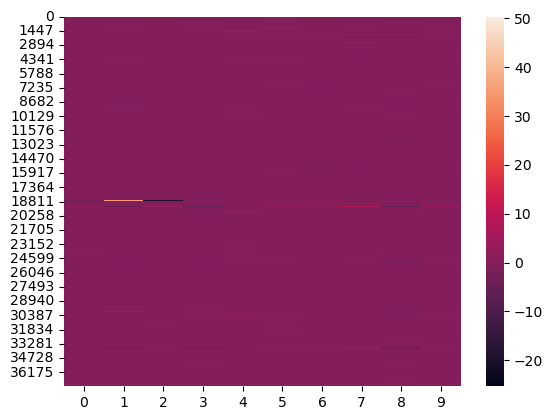

In [24]:
import seaborn as sns
sns.heatmap(data=weights[1])

In [21]:

# Extract factors
# f["expectations"]["Z"]["*"].value

# Extract weights
#f["expectations"]["W"]["gene_expression"].value
#f["expectations"]["W"]["cnv"].value

# Extract variance explained estimates
print(f["variance_explained"]["r2_per_factor"])
print(f["variance_explained"]["r2_total"])

<HDF5 group "/variance_explained/r2_per_factor" (1 members)>
<HDF5 group "/variance_explained/r2_total" (1 members)>


In [36]:
pd.read_csv("data/processed_data/simlilarity_matrix.csv")

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V857,V858,V859,V860,V861,V862,V863,V864,V865,V866
0,1,0.565651,0.001043,0.000867,0.000815,0.000957,0.000724,0.000791,0.000746,0.000955,...,0.001112,0.001226,0.001261,0.000984,0.000771,0.001014,0.000863,0.000786,0.000860,0.000769
1,2,0.001043,0.563758,0.000878,0.000870,0.002234,0.000810,0.000908,0.000818,0.001380,...,0.001727,0.001068,0.001004,0.001163,0.000897,0.001030,0.000943,0.000931,0.000878,0.000880
2,3,0.000867,0.000878,0.582838,0.001032,0.001050,0.001093,0.000887,0.001041,0.000887,...,0.000816,0.000841,0.000923,0.000899,0.001099,0.000920,0.000937,0.000881,0.000917,0.000929
3,4,0.000815,0.000870,0.001032,0.570135,0.000980,0.001196,0.001075,0.001172,0.001005,...,0.000837,0.000860,0.000880,0.001065,0.001191,0.000994,0.001179,0.000971,0.000963,0.001095
4,5,0.000957,0.002234,0.001050,0.000980,0.578585,0.000872,0.000852,0.000821,0.000975,...,0.001109,0.001163,0.000936,0.001046,0.000899,0.001062,0.001119,0.000799,0.000820,0.000879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,862,0.001014,0.001030,0.000920,0.000994,0.001062,0.000894,0.000883,0.000858,0.000892,...,0.000835,0.000952,0.000893,0.000958,0.000929,0.555253,0.001196,0.000837,0.000847,0.000899
862,863,0.000863,0.000943,0.000937,0.001179,0.001119,0.001228,0.000967,0.001186,0.000936,...,0.000849,0.000926,0.000858,0.000916,0.001009,0.001196,0.575172,0.001634,0.002442,0.001054
863,864,0.000786,0.000931,0.000881,0.000971,0.000799,0.001088,0.001382,0.003183,0.000951,...,0.000970,0.000810,0.000779,0.000855,0.001010,0.000837,0.001634,0.562232,0.005268,0.001049
864,865,0.000860,0.000878,0.000917,0.000963,0.000820,0.001157,0.001293,0.002835,0.000979,...,0.000862,0.000869,0.000805,0.000865,0.001027,0.000847,0.002442,0.005268,0.564354,0.001183


(array([3.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 6.000e+00,
        1.400e+01, 1.500e+01, 3.900e+01, 3.700e+01, 5.900e+01, 9.600e+01,
        1.440e+02, 1.950e+02, 2.470e+02, 2.950e+02, 3.320e+02, 3.210e+02,
        3.380e+02, 3.820e+02, 4.170e+02, 4.140e+02, 4.180e+02, 4.560e+02,
        4.920e+02, 5.100e+02, 5.480e+02, 5.300e+02, 5.350e+02, 5.270e+02,
        5.670e+02, 6.000e+02, 5.600e+02, 6.150e+02, 6.480e+02, 7.170e+02,
        7.840e+02, 8.270e+02, 8.660e+02, 9.220e+02, 1.010e+03, 1.099e+03,
        1.168e+03, 1.167e+03, 1.272e+03, 1.435e+03, 1.506e+03, 1.714e+03,
        1.848e+03, 1.922e+03, 2.115e+03, 2.374e+03, 2.469e+03, 2.863e+03,
        3.268e+03, 3.487e+03, 3.714e+03, 3.753e+03, 3.974e+03, 4.283e+03,
        4.396e+03, 4.536e+03, 4.698e+03, 4.746e+03, 4.743e+03, 4.888e+03,
        4.754e+03, 4.791e+03, 4.749e+03, 4.848e+03, 4.780e+03, 4.539e+03,
        4.479e+03, 4.282e+03, 3.995e+03, 3.541e+03, 2.984e+03, 2.413e+03,
        1.917e+03, 1.399e+03, 1.010e+0

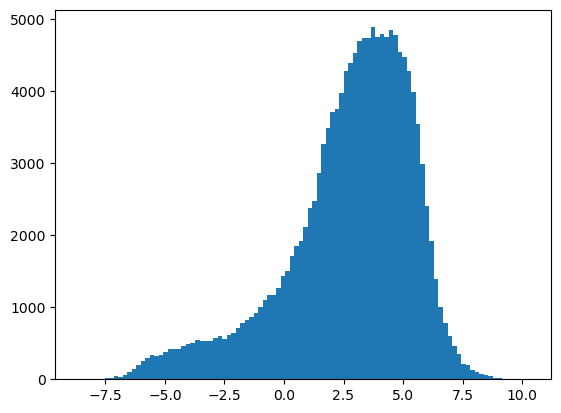

In [38]:
plt.hist(x = selected_experiment['LN_IC50'], bins=100)

## Methylation Data

In [24]:
met_df = pd.read_csv('data/raw_data/F2_METH_CELL_DATA.txt', sep = '\t', index_col=0)
met_df.head()

,8221924127_R04C02,8221924165_R06C02,8359018054_R03C01,8221924118_R06C02,8221924118_R03C01,8221924116_R05C02,8221924120_R03C01,8221924118_R05C01,7970376007_R03C02,7878191001_R05C02,...,9297962143_R03C02,9297962142_R02C02,9297962143_R02C02,9297962142_R04C01,5723654015_R02C02,8221924072_R05C02,7796806034_R02C01,7796806012_R02C01,7786923095_R05C02,7796806008_R03C02
chr1:10003165-10003585,0.192212,0.187603,0.210185,0.205614,0.204037,0.194666,0.201927,0.203396,0.204559,0.200248,...,0.200183,0.264512,0.215756,0.200625,0.216881,0.202672,0.196493,0.201091,0.210533,0.196246
chr1:100315420-100316009,0.203820,0.207652,0.222116,0.227570,0.204111,0.202920,0.213711,0.215140,0.129659,0.216545,...,0.147437,0.150238,0.148527,0.152257,0.191547,0.240531,0.187575,0.171479,0.187861,0.211338
chr1:100435297-100436070,0.277914,0.400146,0.264730,0.303641,0.243705,0.273932,0.316949,0.311206,0.201764,0.260083,...,0.220299,0.275776,0.242513,0.151656,0.258513,0.293938,0.148768,0.236005,0.278650,0.228738
chr1:100503482-100504404,0.190930,0.195871,0.243298,0.250454,0.227564,0.221441,0.245361,0.236868,0.191201,0.208247,...,0.206522,0.212745,0.230850,0.249544,0.243160,0.195461,0.187911,0.203405,0.256763,0.239519
chr1:10057121-10058108,0.544059,0.764898,0.415485,0.599275,0.389168,0.418989,0.710107,0.535424,0.476377,0.852415,...,0.539381,0.276993,0.894927,0.664511,0.275930,0.623589,0.427652,0.462792,0.892354,0.494772


In [21]:
met_df = met_df.T

In [6]:
met_lookup = pd.read_excel('data/raw_data/methSampleId_2_cosmicIds.xlsx', sheet_name=0)

/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [18]:
met_lookup['Sentrix_Barcode'] = list("_".join([i,j]) for i, j in zip(met_lookup['Sentrix_ID'].astype(str), met_lookup['Sentrix_Position']))

In [25]:
tb = dict(zip(met_lookup['Sentrix_Barcode'], met_lookup['Sample_Name']))
met_df.rename(columns=tb, inplace=True)
met_df = met_df.T

## SNV data (Mutation Data)

In [14]:
snv_df = pd.read_csv('data/raw_data/mutations_all_20230202.csv', low_memory=False)
model_list = pd.read_csv('data/raw_data/model_list_20230306.csv', low_memory=False)
snv_df.drop(columns='model_name', inplace=True)

In [15]:
snv_df = snv_df.join(model_list[['model_id', 'model_name']].set_index('model_id'), on="model_id", how="inner")

In [16]:
snv_df.reset_index(drop=True, inplace=True)

 important_only = ['cds_disrupted','complex_sub','downstream', 'ess_splice','frameshift','missense','nonsense','silent','splice_region','start_lost','stop_lost','upstream']


'cds_disrupted', 终止密码子突变
 'complex_sub', 复合物替换突变
 'downstream', 下游
 'ess_splice', 外显子剪辑沉默
 'frameshift', 移码突变
 'inframe', 开放框架内突变
 'intronic', 内显子
 'missense', 错义突变
 'nc_ess_splice', 
 'nc_variant', 
 'nonsense', 无义突变
 'silent', 沉默突变
 'splice_region', 剪辑区域
 'start_lost', 启动子丢失
 'stop_lost', 终止密码子丢失
 'upstream' 上游

In [3]:
important_only = ['cds_disrupted','complex_sub','downstream', 'ess_splice','frameshift','missense','nonsense','silent','splice_region','start_lost','stop_lost','upstream']

In [17]:
snv_df = snv_df[snv_df['effect'].isin(important_only)]

In [18]:
df_table = pd.pivot_table(data=snv_df, 
                          index='model_name', 
                          columns='gene_symbol', 
                          values='effect',
                          aggfunc='count',
                          fill_value=0)